# Section B: Customer Segmentation

Name: Joen Choo Tze En<br>
Admin Number: P2415828<br>
Class: DAAA/FT/1B/03<br>

## Project Objective
Customer-Data dataset contains information of 200 customers including their Gender, Age, Income and How much they spend. <br/>
We want to group the customers into clusters so that we can cater needs for different customers. <br/>
By the end of this study, we aim to answer the following questions.
- How can we perform customer segmentation using unsupervised machine learning algorithms in Python?
- What are the characteristics of each customer cluster?
- Which group of customers needs to be paid more attention?

## Project Backgrond
Factors such as Income and Age can affect the money people are willing to spend.<br/>
This is important for companies as such info can inform them on the revenue that certain people bring

---

In [184]:
# Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing data
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Models
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Evaluation metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

In [185]:
import warnings
warnings.filterwarnings('ignore')

In [186]:
random_state = 42

# Customer Data

In [187]:
# Read Dataset
dataset = pd.read_csv('./Datasets/CA2-Customer-Data.csv')
dataset

,CustomerID,Gender,Age,Income (k$),How Much They Spend
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


Meta Data: 
- CustomerID: the unique ID of the customer
- Gender: gender of the customer
- Age: age of the customer
- Income: the annual income of the customer (in thousand dollars)
- How Much They Spend: how much dollar the customer spend in the shop

# 1 | Basic Analysis

In [188]:
# dataset info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CustomerID           200 non-null    int64 
 1   Gender               200 non-null    object
 2   Age                  200 non-null    int64 
 3   Income (k$)          200 non-null    int64 
 4   How Much They Spend  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


- 200 rows and 5 columns
- CustomerID, Gender, Age and 'How Much They Spend' are numerical columns with type int64 data
- Gender seems to be categorical data
- There are no null values in the dataset

In [189]:
# dataset statistics
dataset.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerID,200.0,NaN,NaN,NaN,100.5,57.879185,1.0,50.75,100.5,150.25,200.0
Gender,200,2,Female,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,200.0,NaN,NaN,NaN,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
Income (k$),200.0,NaN,NaN,NaN,60.56,26.264721,15.0,41.5,61.5,78.0,137.0
How Much They Spend,200.0,NaN,NaN,NaN,50.2,25.823522,1.0,34.75,50.0,73.0,99.0


- There are more females than males, 112 to 88
- Average age is 38-39 years
- Average income is $60.5k per year
- Average spending amount is $50
- CustomerID is a unique Identifier

# 2 | Data Visualisation

In [190]:
numerical_cols = ['Age', 'Income (k$)', 'How Much They Spend']

In [191]:
fig, ax = plt.subplots(1, 3, figsize=(14,5), facecolor='whitesmoke', tight_layout=True)

for i, col in enumerate(dataset[numerical_cols].columns):
    sns.histplot(dataset[col], kde=True, ax=ax[i], bins='auto')
    ax[i].set_title(f"Histogram of {col}")
    ax[i].set_xlabel("Value")
    ax[i].set_ylabel("Frequency")

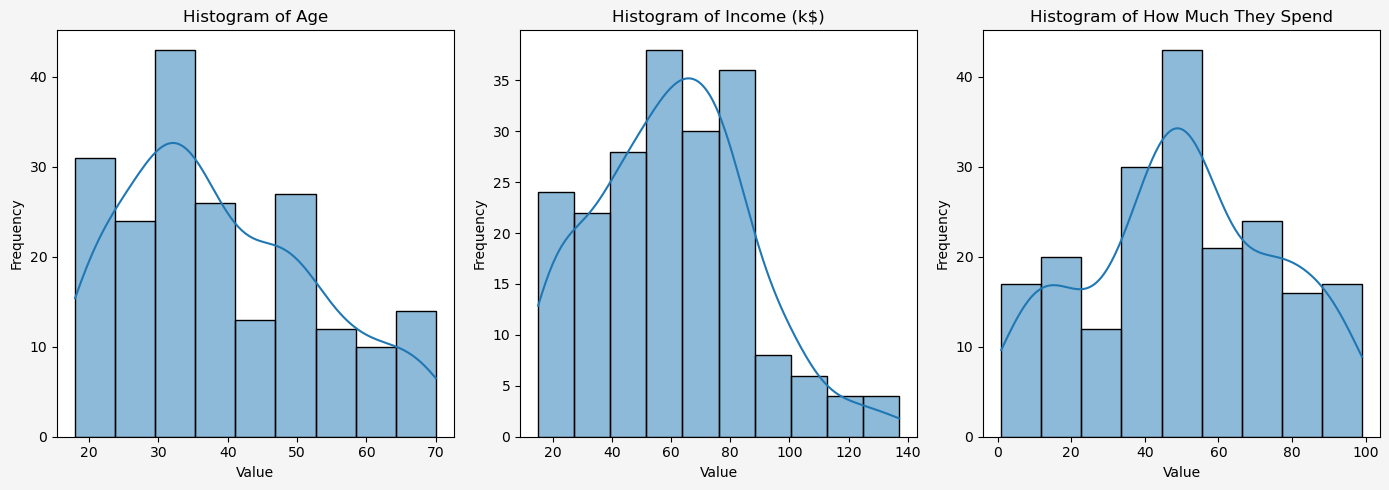

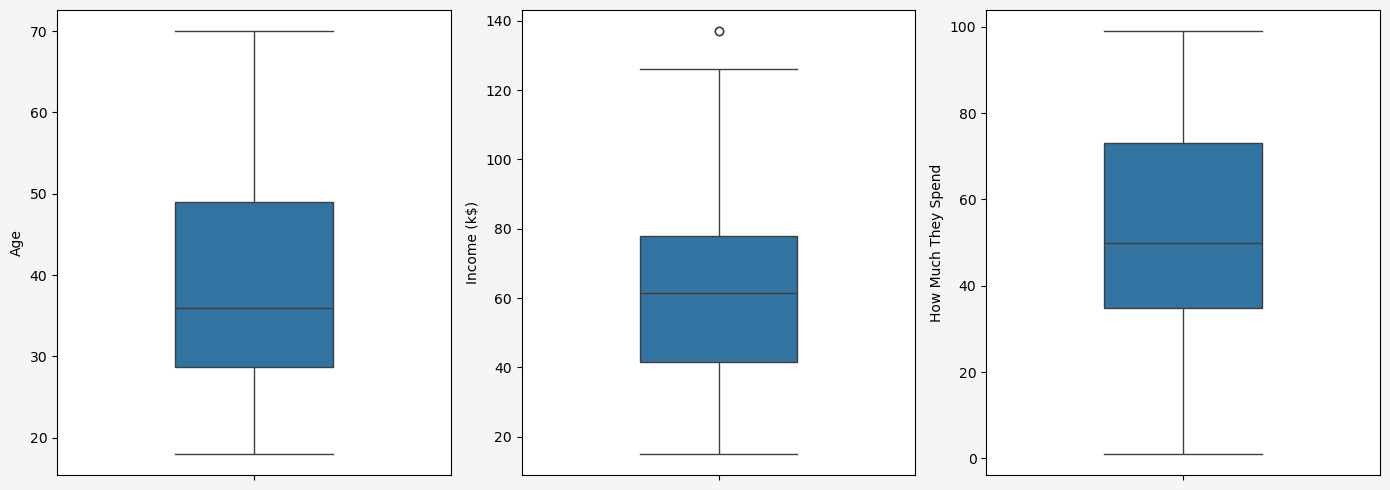

In [192]:
fig, ax = plt.subplots(1, 3, figsize=(14,5), facecolor='whitesmoke', tight_layout=True)

for i, col in enumerate(dataset[numerical_cols].columns):
    sns.boxplot(dataset[col], widths=0.4, ax=ax[i])
    
plt.show()

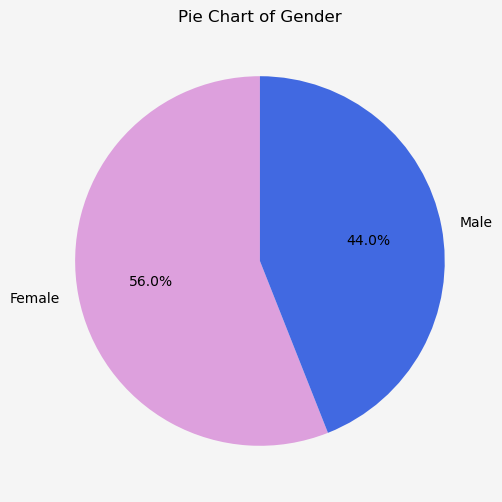

In [193]:
gender_count = dataset['Gender'].value_counts()

plt.figure(figsize=(6,6), facecolor='whitesmoke')
plt.pie(gender_count.values, labels = gender_count.index, autopct = '%1.1f%%', colors=['plum', 'royalblue'], startangle=90)
plt.title("Pie Chart of Gender")
plt.show()

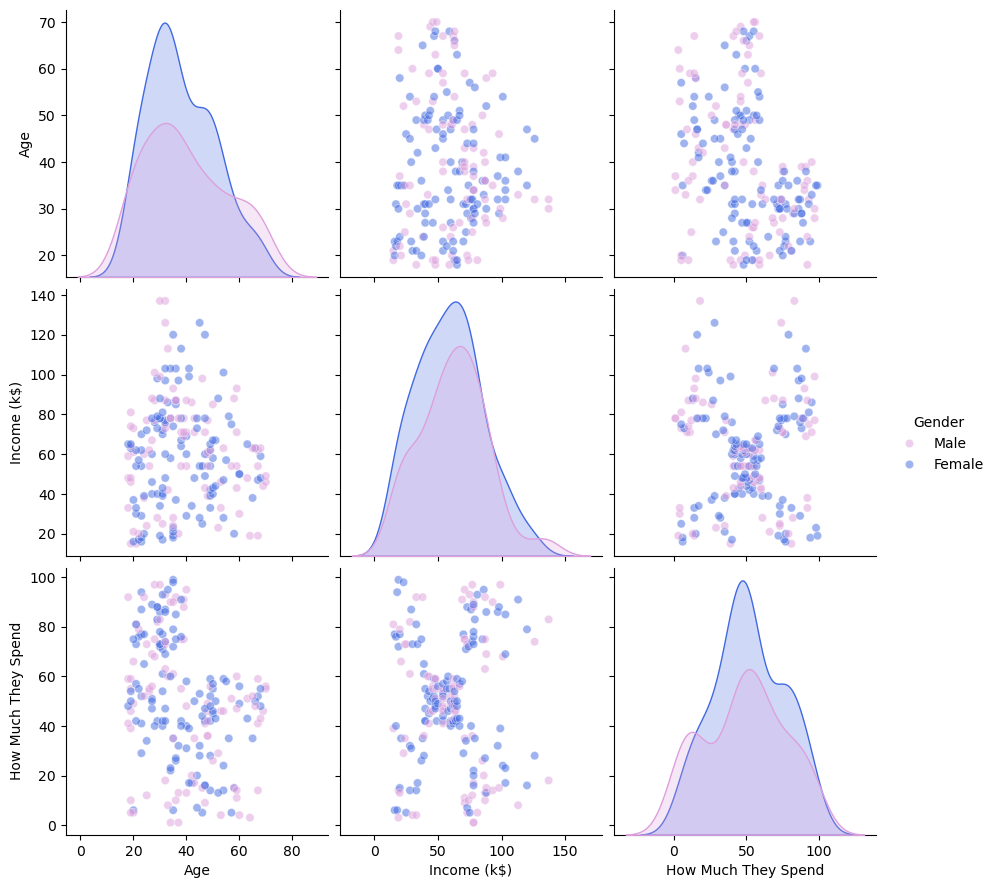

In [194]:
#Pairplot of variables
sns.pairplot(dataset[numerical_cols + ['Gender']], hue="Gender", plot_kws={"alpha":0.5}, palette=['plum', 'royalblue'], height=3)
plt.show()

# 3 | Data Cleaning

In [195]:
# Drop Unique Identifier 'CustomerID'
dataset.drop("CustomerID", axis=1, inplace=True)
# Rename 'How Much They Spend' to a shorter 'Amount Spent ($)'
dataset = dataset.rename(columns={"How Much They Spend":"Amount Spent ($)"})
customer_df = dataset.copy()
display(dataset.head())

,Gender,Age,Income (k$),Amount Spent ($)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [196]:
# Label Encoding
customer_df["Gender"] = LabelEncoder().fit_transform(customer_df["Gender"])
customer_df.head()

,Gender,Age,Income (k$),Amount Spent ($)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


- 1 is 'Male' and 0 is 'Female'

In [197]:
#Standardize all numerical columns
numerical_cols = ["Age", "Income (k$)", "Amount Spent ($)"]
customer_df[numerical_cols]=StandardScaler().fit_transform(customer_df[numerical_cols])
customer_df.head()

,Gender,Age,Income (k$),Amount Spent ($)
0,1,-1.424569,-1.738999,-0.434801
1,1,-1.281035,-1.738999,1.195704
2,0,-1.352802,-1.700830,-1.715913
3,0,-1.137502,-1.700830,1.040418
4,0,-0.563369,-1.662660,-0.395980


- Now data is standardized and encoded for modelling

# 4 | Dimension Reduction

### Principal Component Anaylsis (PCA)

In [198]:
pca = PCA(n_components=3)
pca_df = pca.fit_transform(customer_df)

x1 = pca_df[:, 0]
x2 = pca_df[:, 1]
x3 = pca_df[:, 2]

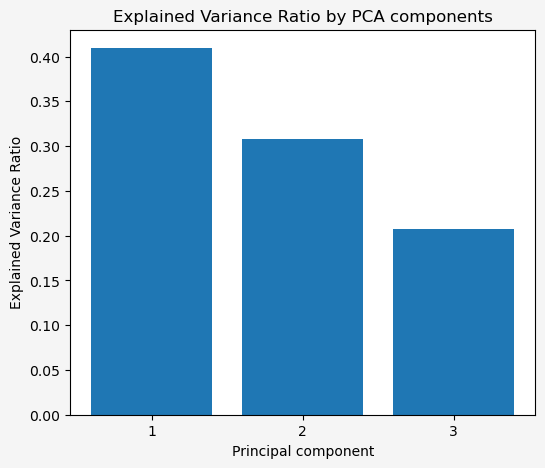

In [199]:
plt.figure(figsize=(6,5), facecolor='whitesmoke')
plt.bar(range(1, 4), pca.explained_variance_ratio_)
plt.xlabel('Principal component')
plt.xticks(range(1, 4))
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by PCA components')
plt.show()

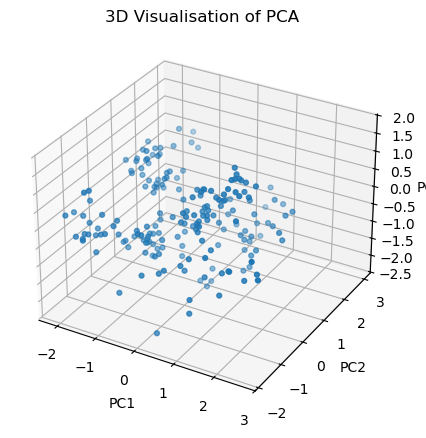

In [200]:
# %matplotlib tk
%matplotlib inline

fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
ax.scatter(x1, x2, x3, s=12)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D Visualisation of PCA')
plt.show()

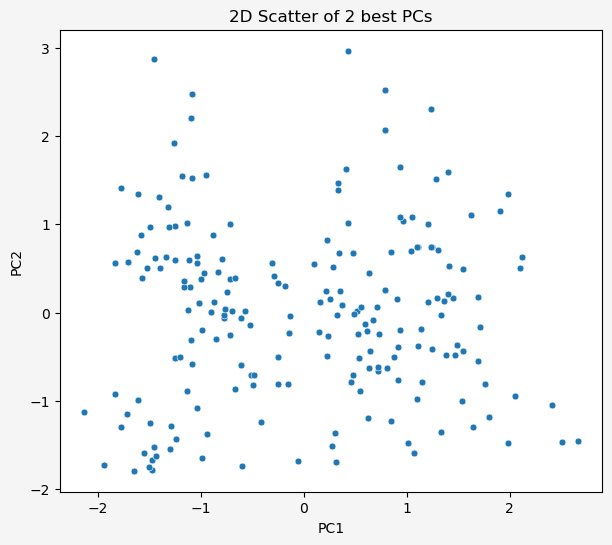

In [330]:
plt.figure(figsize=(7,6), facecolor='whitesmoke')
sns.scatterplot(x=x1, y=x2, s=24)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D Scatter of 2 best PCs')
plt.show()

### t-SNE

In [202]:
tsne = TSNE(learning_rate=15, perplexity=30, random_state=random_state, n_components=2)
tsne_df = tsne.fit_transform(customer_df)

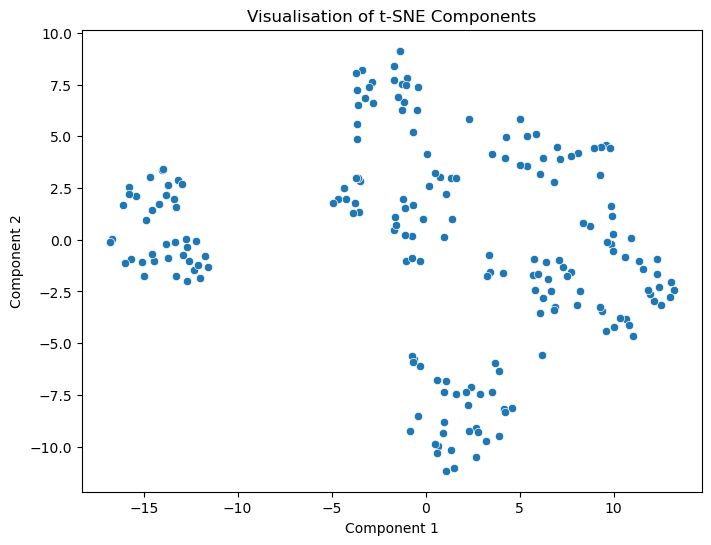

In [203]:
def plot_tsne(labels = []):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=tsne_df[:, 0], y=tsne_df[:,1], hue = labels, palette='tab10')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title("Visualisation of t-SNE Components")
    plt.show()

plot_tsne()

# 5 | Modelling

Evaluation Metrics used:
- Silhouette Score - Measures how similar data points are within a cluster compared to other clusters.
- Calinski-Harabasz Index (CHI) - Measures the *ratio* of between-cluster dispersion to within-cluster dispersion.
- Davies-Bouldin Index (DBI) - Measures average similarity between clusters.

## Kmeans

In [204]:
silhouette_scores=[]
for k in range(2,11):
    kmeans=KMeans(n_clusters=k, random_state=random_state).fit(customer_df)
    label = kmeans.labels_
    sil_coef=silhouette_score(customer_df, label, metric='euclidean')
    silhouette_scores.append(sil_coef)
    print(f"For n_clusters={k}, The Silhouette Coefficient is {sil_coef:.3f}")

For n_clusters=2, The Silhouette Coefficient is 0.303
For n_clusters=3, The Silhouette Coefficient is 0.312
For n_clusters=4, The Silhouette Coefficient is 0.350
For n_clusters=5, The Silhouette Coefficient is 0.350
For n_clusters=6, The Silhouette Coefficient is 0.356
For n_clusters=7, The Silhouette Coefficient is 0.332
For n_clusters=8, The Silhouette Coefficient is 0.336
For n_clusters=9, The Silhouette Coefficient is 0.312
For n_clusters=10, The Silhouette Coefficient is 0.309


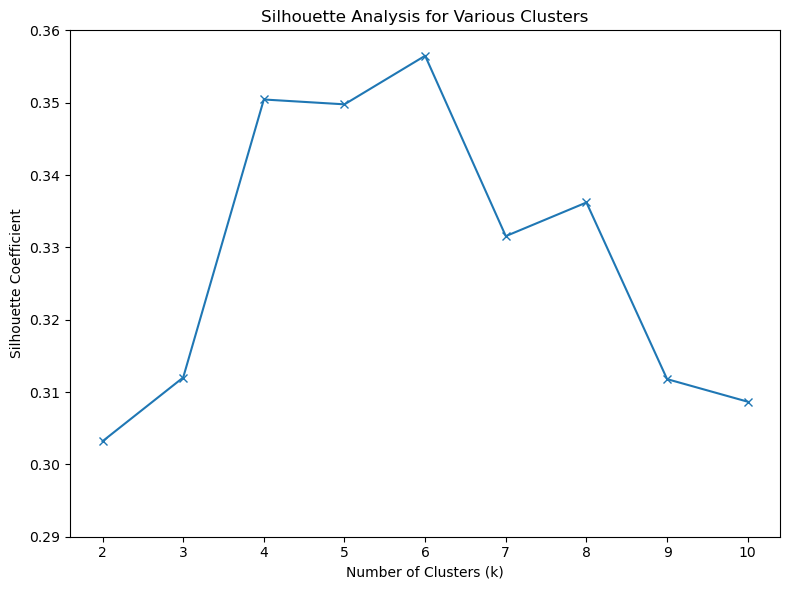

In [205]:
plt.figure(figsize=(8,6))
plt.plot(range(2,11), silhouette_scores, "x-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Coefficient")
plt.title("Silhouette Analysis for Various Clusters")
plt.yticks(np.arange(0.29, 0.361, 0.01))

plt.tight_layout()
plt.show()

**Observations:**
- Best number of k clusters is 6 as it has the highest silhouette score, followed closely by k=5 and 4.

Silhouette Score: 0.356485834425401
CHI score: 99.65487851108833
DBI score: 1.0050904211940697


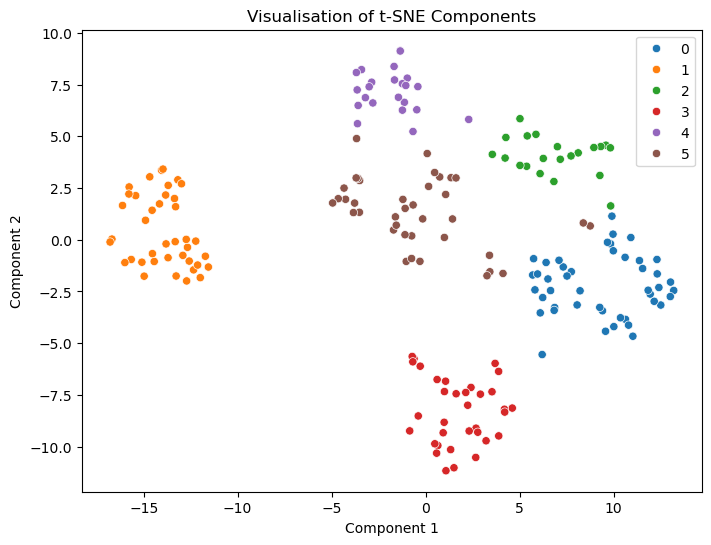

In [221]:
kmeans_model = KMeans(n_clusters=6, random_state=random_state).fit(customer_df)
print("Silhouette Score:", silhouette_score(customer_df, kmeans_model.labels_, metric='euclidean'))
print("CHI score:", calinski_harabasz_score(customer_df, kmeans_model.labels_))
print("DBI score:", davies_bouldin_score(customer_df, kmeans_model.labels_))

plot_tsne(labels = kmeans_model.labels_)

We can also try n_clusters=5 and 4.

Silhouette Score: 0.34977050035201074
CHI score: 97.25832335913093
DBI score: 1.0245227921150648


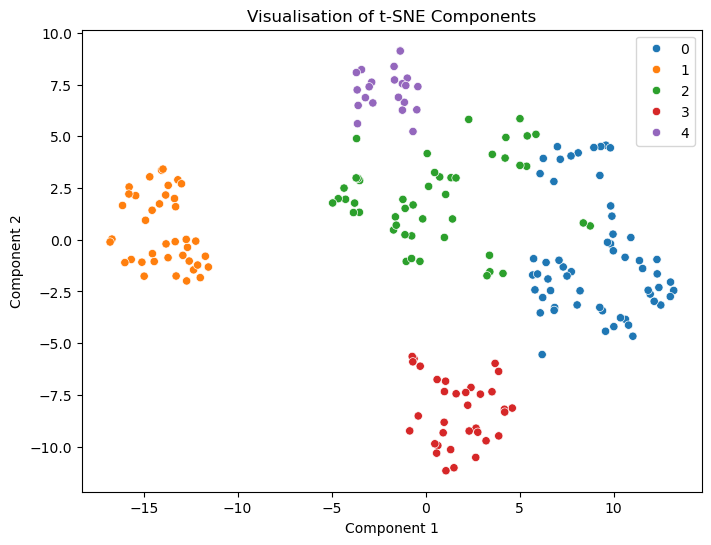

In [305]:
kmeans_model = KMeans(n_clusters=5, random_state=random_state).fit(customer_df)
print("Silhouette Score:", silhouette_score(customer_df, kmeans_model.labels_, metric='euclidean'))
print("CHI score:", calinski_harabasz_score(customer_df, kmeans_model.labels_))
print("DBI score:", davies_bouldin_score(customer_df, kmeans_model.labels_))

plot_tsne(labels = kmeans_model.labels_)

Silhouette Score: 0.35044061449694197
CHI score: 101.43557996114865
DBI score: 1.0692701106525715


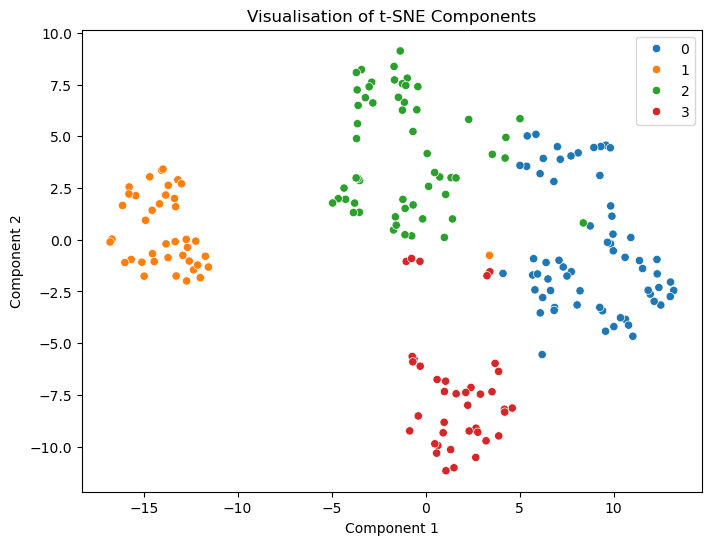

In [306]:
kmeans_model = KMeans(n_clusters=4, random_state=random_state).fit(customer_df)
print("Silhouette Score:", silhouette_score(customer_df, kmeans_model.labels_, metric='euclidean'))
print("CHI score:", calinski_harabasz_score(customer_df, kmeans_model.labels_))
print("DBI score:", davies_bouldin_score(customer_df, kmeans_model.labels_))

plot_tsne(labels = kmeans_model.labels_)

- Although not having clusters as well defined as k=6, an argument could be made that they are valid clusters of data

## DBSCAN

Silhouette Score: -0.011387465358068808
CHI score: 10.8905686733236
DBI score: 1.5008184621600698


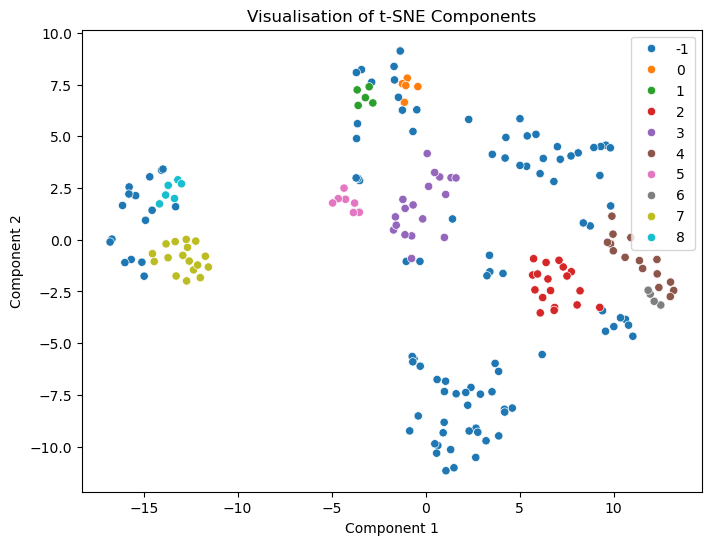

In [220]:
# Fit the DBSCAN model
dbscan = DBSCAN().fit(customer_df)
print("Silhouette Score:", silhouette_score(customer_df, dbscan.labels_))
print("CHI score:", calinski_harabasz_score(customer_df, dbscan.labels_))
print("DBI score:", davies_bouldin_score(customer_df, dbscan.labels_))
plot_tsne(dbscan.labels_)

- There are many outliers that DBSCAN was not able to cluster (in blue)
- The varaious metrics have poor scores

In [218]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

# DBSCAN Param Grid
param_grid = {
    'eps':[i for i in np.arange(0.75, 2, 0.01)], 
    'min_samples':[i for i in range(2, 10)]
}

# Grid Search CV
km_grid_search = GridSearchCV(DBSCAN(), param_grid=param_grid, cv=5, scoring=silhouette_scorer, n_jobs=-1)

km_grid_search.fit(customer_df)

print("Best Parameters:", km_grid_search.best_params_)
print("Best Score:", km_grid_search.best_score_)

Best Parameters: {'eps': 0.79, 'min_samples': 2}
Best Score: 0.31321634552734445


Silhouette Score: 0.0008251135593089387
CHI score: 11.683218707784468
DBI score: 1.6550356004642395


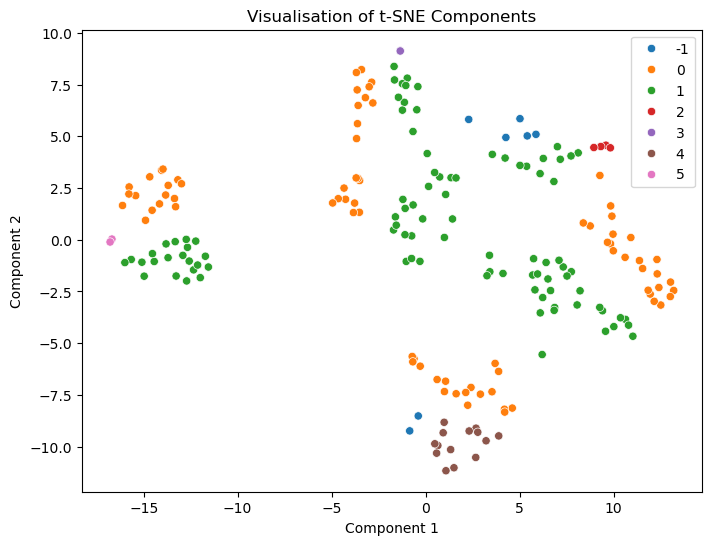

In [209]:
# Fit the DBSCAN model
dbscan = DBSCAN(eps=0.79, min_samples=2).fit(customer_df)
print("Silhouette Score:", silhouette_score(customer_df, dbscan.labels_))
print("CHI score:", calinski_harabasz_score(customer_df, dbscan.labels_))
print("DBI score:", davies_bouldin_score(customer_df, dbscan.labels_))
plot_tsne(dbscan.labels_)

- Silhouette score is still very low, clusters show no pattern
- We cannot use the DBSCAN model for this clustering problem

## Agglomerative Clustering

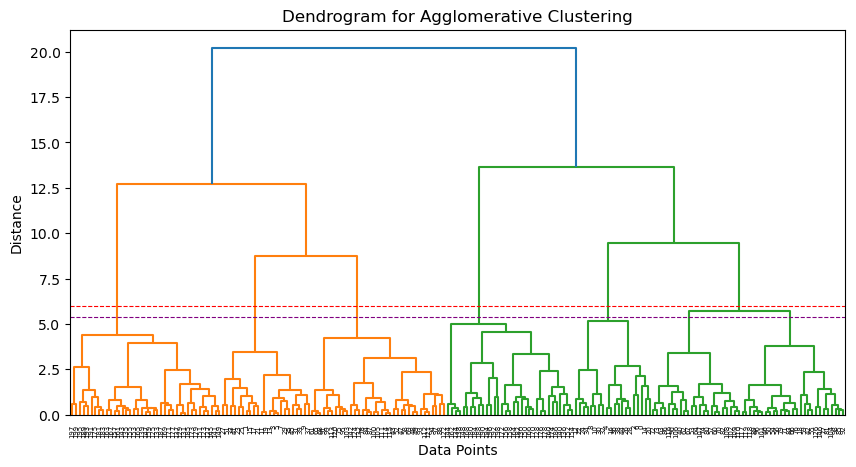

In [317]:
linkage_matrix = linkage(customer_df, method='ward')
# Ward Linkage method measures the distance between clusters

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title("Dendrogram for Agglomerative Clustering")
plt.xlabel("Data Points")
plt.ylabel("Distance")

plt.axhline(y=6, color='red', linestyle="--", linewidth=0.8)
plt.axhline(y=5.4, color='purple', linestyle="--", linewidth=0.8)
plt.show()

- We can try picking a threshold where the furthest distance is observed
- In this case it is at around a distance of 6 (seen by the line), and there are 6 clusters

Silhouette Score: 0.3504439354681972
CHI score: 95.2576612909977
DBI score: 1.0086149926438526


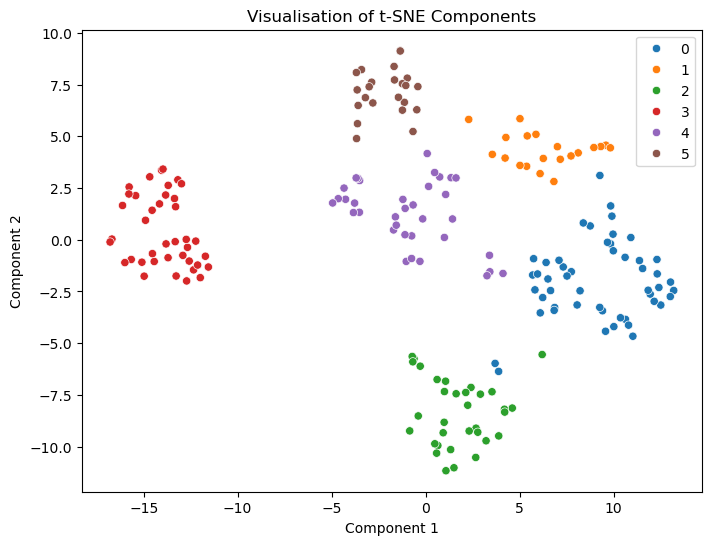

In [ ]:
agg_model = AgglomerativeClustering(n_clusters=6).fit(customer_df)
print("Silhouette Score:", silhouette_score(customer_df, agg_model.labels_))
print("CHI score:", calinski_harabasz_score(customer_df, agg_model.labels_))
print("DBI score:", davies_bouldin_score(customer_df, agg_model.labels_))
plot_tsne(agg_model.labels_)

From the dendrogram, a distance of 5.4 can also be a good threshold which would give us 7 clusters

Silhouette Score: 0.3154051514048088
CHI score: 89.60550039463337
DBI score: 1.0710736333907196


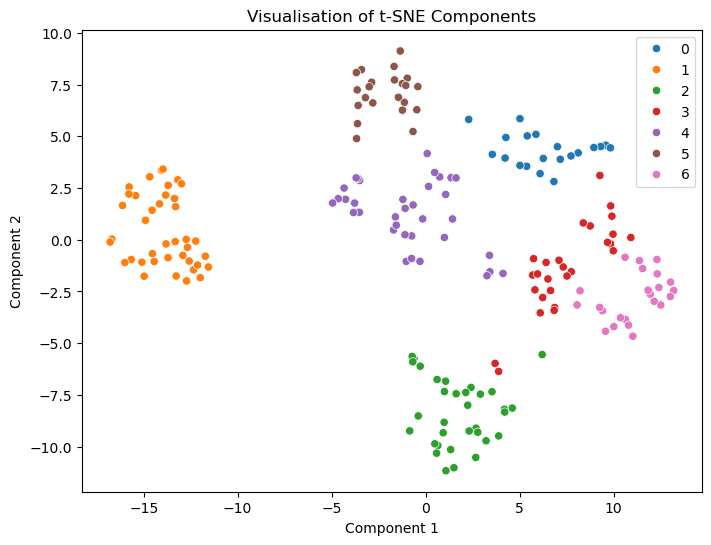

In [318]:
agg_model = AgglomerativeClustering(n_clusters=7).fit(customer_df)
print("Silhouette Score:", silhouette_score(customer_df, agg_model.labels_))
print("CHI score:", calinski_harabasz_score(customer_df, agg_model.labels_))
print("DBI score:", davies_bouldin_score(customer_df, agg_model.labels_))
plot_tsne(agg_model.labels_)

However it is not as defined as k=6

In [ ]:
# Using Silhouette score to improve model
best_score = -1
best_threshold, best_n_clusters = None, None

for t in np.arange(1.5, 10, 0.1):
    clusters = fcluster(linkage_matrix, t, criterion='distance')
    
    if len(set(clusters)) > 1:
        agc = AgglomerativeClustering(n_clusters=len(set(clusters))).fit(customer_df)
        score = silhouette_score(customer_df, agc.labels_, metric='euclidean')
        if score > best_score:
            best_score = score
            best_threshold = t
            best_n_clusters = len(set(clusters))

print("Best Threshold Distance:", best_threshold)
print("Best Silhouette Score:", best_score)
print("n_clusters of best score:", best_n_clusters)

Best Threshold Distance: 1.7000000000000002
Best Silhouette Score: 0.3762343835929661
n_clusters of best score: 31


- Although Silhouette score is optimized, there are too many clusters for it to be considered an optimized model

In [213]:
best_score = -1
best_threshold, best_n_clusters = None, None

for t in np.arange(2.5, 10, 0.1):
    clusters = fcluster(linkage_matrix, t, criterion='distance')
    
    if len(set(clusters)) > 1:
        agc = AgglomerativeClustering(n_clusters=len(set(clusters))).fit(customer_df)
        score = silhouette_score(customer_df, agc.labels_, metric='euclidean')
        if score > best_score:
            best_score = score
            best_threshold = t
            best_n_clusters = len(set(clusters))

print("Best Threshold Distance:", best_threshold)
print("Best Silhouette Score:", best_score)
print("n_clusters of best score:", best_n_clusters)

Best Threshold Distance: 5.8000000000000025
Best Silhouette Score: 0.3504439354681972
n_clusters of best score: 6


- It seems we get the same number of n_clusters as before

## Gaussian Mixture Model

In [214]:
silhouette_scores=[]
for k in range(2,11):
    gmm=GaussianMixture(n_components=k, random_state=random_state).fit(customer_df)
    label = gmm.predict(customer_df)
    sil_coef=silhouette_score(customer_df, label, metric='euclidean')
    silhouette_scores.append(sil_coef)
    print(f"For n_clusters={k}, The Silhouette Coefficient is {sil_coef:.3f}")

For n_clusters=2, The Silhouette Coefficient is 0.295
For n_clusters=3, The Silhouette Coefficient is 0.294
For n_clusters=4, The Silhouette Coefficient is 0.327
For n_clusters=5, The Silhouette Coefficient is 0.332
For n_clusters=6, The Silhouette Coefficient is 0.344
For n_clusters=7, The Silhouette Coefficient is 0.307
For n_clusters=8, The Silhouette Coefficient is 0.290
For n_clusters=9, The Silhouette Coefficient is 0.253
For n_clusters=10, The Silhouette Coefficient is 0.027


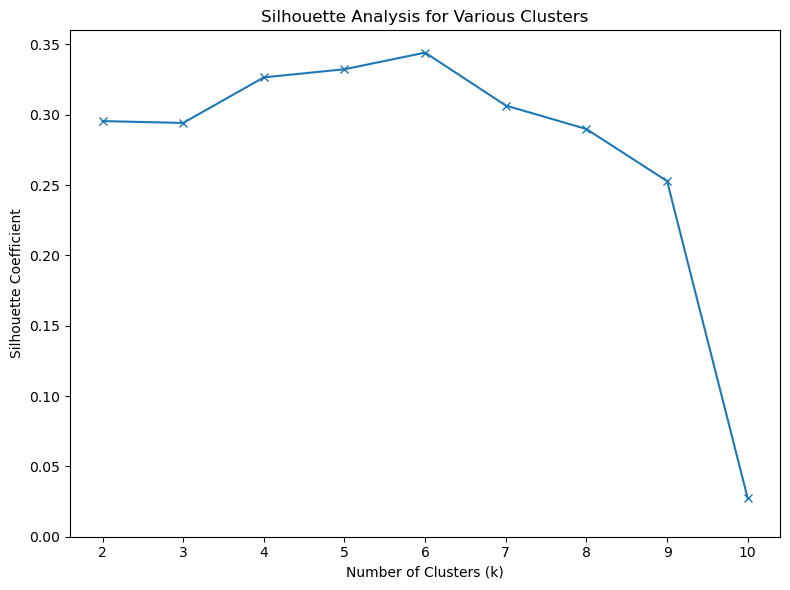

In [215]:
plt.figure(figsize=(8,6))
plt.plot(range(2,11), silhouette_scores, "x-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Coefficient")
plt.title("Silhouette Analysis for Various Clusters")
plt.yticks(np.arange(0, 0.36, 0.05))

plt.tight_layout()
plt.show()

Silhouette Score: 0.3441357128700915
CHI score: 92.60218569916051
DBI score: 1.0297531466094894


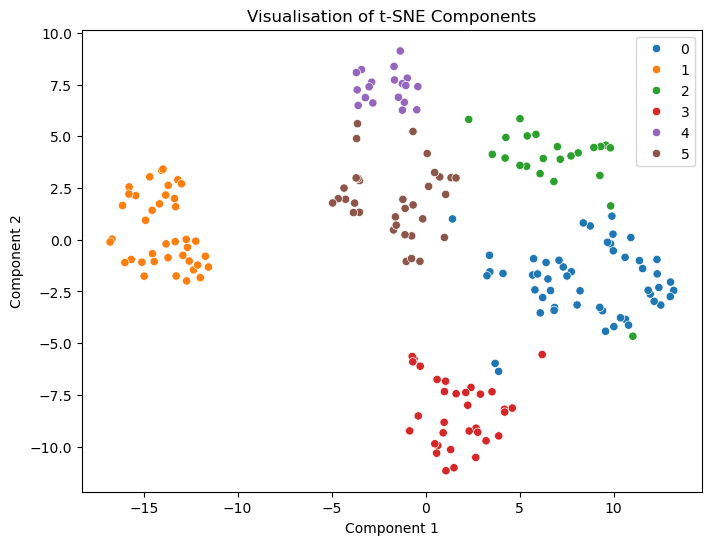

In [216]:
gm_model = GaussianMixture(n_components=6, random_state=random_state).fit(customer_df)
gm_labels = gm_model.predict(customer_df)
print("Silhouette Score:", silhouette_score(customer_df, gm_labels))
print("CHI score:", calinski_harabasz_score(customer_df, gm_labels))
print("DBI score:", davies_bouldin_score(customer_df, gm_labels))
plot_tsne(labels = gm_labels)

# 6 | Summary and Interpretation

(excluding DBSCAN)
- All t-SNE by cluster visualisations of models look similar
- KMeans slightly beats out otther models in terms of metrics<br/>
  Only noticable difference from other models in CHI ratio, the model handles balance of dispersion within clusters and between clusters well

<p>Therefore, we will use KMeans clustering algorithm as our final model</p>

In [325]:
kmeans_model = KMeans(n_clusters=6, random_state=random_state).fit(customer_df)

dataset['cluster'] = kmeans_model.labels_
dataset.head()

,Gender,Age,Income (k$),Amount Spent ($),cluster
0,Male,19,15,39,4
1,Male,21,15,81,4
2,Female,20,16,6,2
3,Female,23,16,77,4
4,Female,31,17,40,2


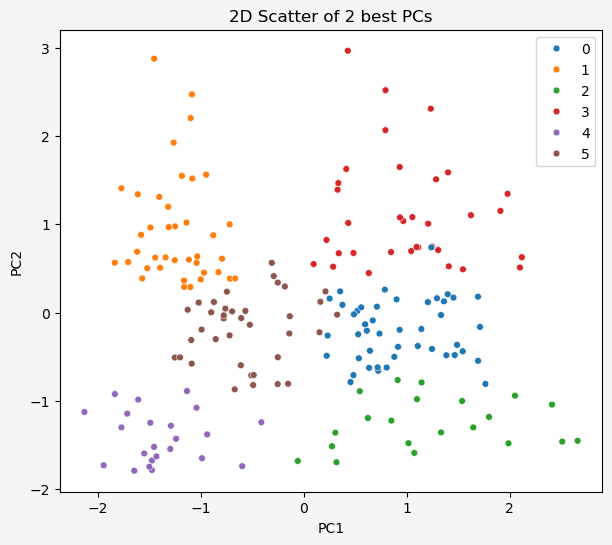

In [331]:
plt.figure(figsize=(7,6), facecolor='whitesmoke')
sns.scatterplot(x=x1, y=x2, hue=kmeans_model.labels_, s=24, palette='tab10')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D Scatter of 2 best PCs')
plt.show()

- Could be used to confirm that PC1 could = Amount Spent, PC2 could = Income
- Thus we can conclude that Amount spent and Income have highest importance and high correlation with each other

In [304]:
cluster_summary = dataset.groupby('cluster').agg({
    'Age': ['mean', 'median'],
    'Income (k$)': ['mean', 'median'],
    'Amount Spent ($)': ['mean', 'median']
}).apply(lambda x:round(x, 2))

clusters_bygender = pd.DataFrame(dataset.groupby(["cluster", "Gender"])["Gender"].count())
display(cluster_summary)
display(clusters_bygender)

Age        Income (k$)        Amount Spent ($)       
          mean median        mean median             mean median
cluster                                                         
0        56.33   54.0       54.27   54.0            49.07   49.0
1        32.69   32.0       86.54   79.0            82.13   83.0
2        45.52   46.0       26.29   25.0            19.38   15.0
3        41.26   42.5       88.50   85.5            16.76   15.5
4        25.00   23.0       25.26   24.0            77.61   77.0
5        27.00   26.5       56.66   59.5            49.13   50.0

Gender
cluster Gender        
0       Female      26
        Male        19
1       Female      21
        Male        18
2       Female      13
        Male         8
3       Female      14
        Male        20
4       Female      13
        Male        10
5       Female      25
        Male        13

### Characteristics of Clusters

- Cluster 0:
    - Mid 50s
    - 54k Annual Income (Moderate)
    - Moderate Average Spending of 49
    - Predominantly females
- Cluster 1:
    - Early 30s
    - 80-86k Annual Income (High)
    - High Average Spending of 82
    - Approximately equal proportion of males and females
- Cluster 2:
    - Mid 40s
    - 25-26k Annual Income (Low)
    - Low Average Spending of 19
    - Predominantly females
- Cluster 3:
    - Early 40s
    - 85-88k Annual Income (High)
    - Low Average Spending of 16
    - Predominantly males
- Cluster 4:
    - Mid 20s
    - 25k Annual Income (Low)
    - High Average Spending of 77
    - Approximately equal proportion of males and females
- Cluster 5:
    - Late 20s
    - 56-59k Annual Income (Moderate)
    - Moderate Average Spending of 49
    - Predominantly females

Possible description of Clusters
- Cluster 0: Average earners and spenders, near the upper range of ages.
- Cluster 1: Young high income individuals that will spend more from their wealth.
- Cluster 2: Adults with low incomes but also manage their money by not spending loosely or largely.
- Cluster 3: High income earning adults who still want to save and not spend much.
- Cluster 4: Youths who don't earn much yet spend a lot, often way over their means.
- Cluster 5: Young adults who earn a moderate amount of money and spend a moderate amount, they save and spend in moderation.

Cluster that needs attention: The young high eearning, high spenders<br/>
They provide the most profit and revenue for businesses, as they have the wealth and are not afraid to spend it. Giving them more opportunities to spend might benefit businesses